In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('E:\\MS\\DL\\Try2\\deep-learning-spring-2025-project-1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar_test_nolabel.pkl
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\batches.meta
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\data_batch_1
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\data_batch_2
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\data_batch_3
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\data_batch_4
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\data_batch_5
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\readme.html
E:\MS\DL\Try2\deep-learning-spring-2025-project-1\cifar-10-python\cifar-10-batches-py\test_batch


In [12]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes_dict = unpickle("deep-learning-spring-2025-project-1\\cifar-10-python\\cifar-10-batches-py\\batches.meta")
label_names = classes_dict[b'label_names']
print(label_names)

# Load training data in batches, then combine
training_data = []
training_labels = []
for i in range(1, 6):
    training_fp = "deep-learning-spring-2025-project-1\\cifar-10-python\\cifar-10-batches-py\\data_batch_{}".format(i)
    batch = unpickle(training_fp)
    batch_data = batch[b'data']
    batch_labels = batch[b'labels']
    for i in range(len(batch_data)):
        training_data.append(batch_data[i])
        training_labels.append(batch_labels[i])

print(len(training_data))
print(len(training_labels))

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
50000
50000


In [13]:
training_labels = np.array(training_labels)

def transform_image(image):
    image = transforms.ToPILImage()(image) # Required for plt display
    image = transforms.RandomHorizontalFlip()(image)
    image = transforms.RandomRotation(15)(image)
    image = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)(image)
    image = transforms.RandomResizedCrop(32, scale=(0.8, 1.0))(image)
    image = transforms.ToTensor()(image) 
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image) # common mean / std. dev numbers cited in Pytorch docs
    return image

print(training_data[0].shape)
# Reshape the array to (N, 3, 32, 32), then rearrange to (N, 32, 32, 3) for transformations
training_data = np.array(training_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
print(training_data[0].shape)

# Commenting out visual displays for now because the After version would have to be in PIL Image mode, not Tensor

# Test on the first image
# print('Sample Image Before:')
# plt.figure(figsize=(3, 3))
# plt.title('Sample Image Before:')
# plt.imshow(training_data[0])
# plt.axis('off')

# plt.figure(figsize=(3, 3))
# plt.title('Sample Image After:')
# transformed_image = transform_image(training_data[0])
# plt.imshow(transformed_image)
# plt.axis('off')

# Apply transformatiosn, shape will now be (3, 32, 32) - default convention for PyTorch NN
training_data = [(transform_image(image), label) for image, label in zip(training_data, training_labels)]
print(training_data[0][0].shape)

(3072,)
(32, 32, 3)
torch.Size([3, 32, 32])


In [14]:
training_count = int(0.8 * len(training_data))
validation_count = int(0.2 * len(training_data))

training_data, validation_data = random_split(training_data, [training_count, validation_count])

In [15]:
# Load the test data
test_fp = "deep-learning-spring-2025-project-1\\cifar-10-python\\cifar-10-batches-py\\test_batch"
test_batch = unpickle(test_fp)
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

# Reshape and apply transformations to the test data
test_data = np.array(test_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Apply the same transformations to the test data
test_data = [(transform_image(image), label) for image, label in zip(test_data, test_labels)]

# Now test_data is in the same format as training_data
print(test_data[0][0].shape)  # Check the shape of a transformed image from the test set


torch.Size([3, 32, 32])


In [16]:
import torch
from torch.utils.data import DataLoader, Dataset

# Custom dataset class to handle our transformed data
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Assuming `test_data` and `test_labels` are the transformed data and labels
test_dataset = CustomDataset(test_data, test_labels, transform=None)  # No need for transformation here

# Create DataLoader for the test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class SmallBalancedResNet(nn.Module):
    def __init__(self):
        super(SmallBalancedResNet, self).__init__()

        # First Convolution Layer (changed kernel size to 5x5)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Residual Blocks (keeping 3x3 kernels)
        self.layer1 = self._make_layer(32, 64, 3, stride=2)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)

        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Increased dropout before fully connected layer
        self.dropout = nn.Dropout(p=0.5)  # Increased from 0.3 to 0.5

        # Fully connected layer
        self.fc = nn.Linear(256, 10)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(in_channels, out_channels, stride))
            in_channels = out_channels  # Update in_channels for next block
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # Initial conv + batch norm + relu
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)  # Global average pooling
        x = torch.flatten(x, 1)  # Flatten to feed to final layer
        x = self.dropout(x)  # Apply dropout before final FC layer
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Dropout added here to prevent overfitting in feature extraction
        #self.dropout = nn.Dropout(p=0.2) #change here

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))  # First convolution + batch norm + relu
        out = self.bn2(self.conv2(out))  # Second convolution + batch norm
        #out = self.dropout(out)  # Dropout applied before adding shortcut
        out += self.shortcut(x)  # Add the shortcut (residual connection)
        out = self.relu(out)  # Apply ReLU to the final result
        return out

# Create an instance of the model
model = SmallBalancedResNet()

# Define optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay

# Print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 4485930


In [27]:
import torch.optim as optim
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallBalancedResNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,400
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          18,432
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]           2,048
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
       BasicBlock-12           [-1, 64, 16, 16]               0
           Conv2d-13             [-1, 64, 8, 8]          36,864
      BatchNorm2d-14             [-1, 6

Epoch 1: Training Loss: 1.8506, Training Accuracy: 32.45%, Validation Accuracy: 39.75%, LR: 0.001000
Epoch 2: Training Loss: 1.5150, Training Accuracy: 45.48%, Validation Accuracy: 45.35%, LR: 0.001000
Epoch 3: Training Loss: 1.3437, Training Accuracy: 52.56%, Validation Accuracy: 53.61%, LR: 0.001000
Epoch 4: Training Loss: 1.2153, Training Accuracy: 57.80%, Validation Accuracy: 56.60%, LR: 0.001000
Epoch 5: Training Loss: 1.0886, Training Accuracy: 62.22%, Validation Accuracy: 59.84%, LR: 0.001000
Epoch 6: Training Loss: 0.9846, Training Accuracy: 66.05%, Validation Accuracy: 61.45%, LR: 0.001000
Epoch 7: Training Loss: 0.8929, Training Accuracy: 69.30%, Validation Accuracy: 62.95%, LR: 0.001000
Epoch 8: Training Loss: 0.8025, Training Accuracy: 72.62%, Validation Accuracy: 63.51%, LR: 0.001000
Epoch 9: Training Loss: 0.7186, Training Accuracy: 75.61%, Validation Accuracy: 62.97%, LR: 0.001000
Epoch 10: Training Loss: 0.6394, Training Accuracy: 78.21%, Validation Accuracy: 63.43%, LR

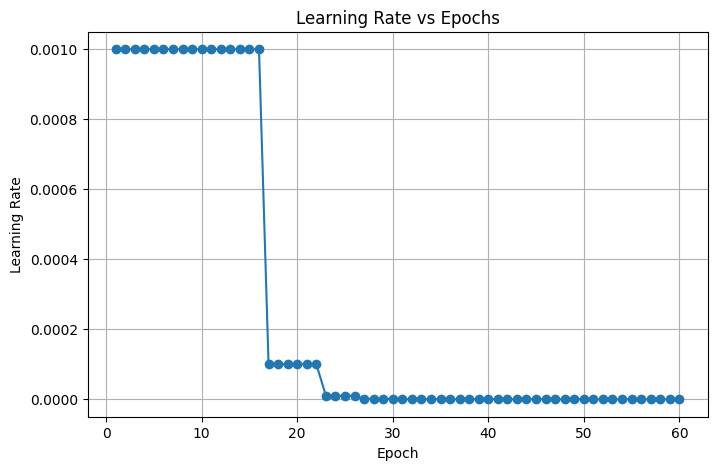

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.10, patience=3)

# DataLoaders
training_loader = DataLoader(training_data, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step(val_acc)

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define your model (ensure it matches the saved model architecture)
model = SmallBalancedResNet()  # Replace with your actual model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Try loading the saved model checkpoint
model_path = "small_balanced_resnet.pth"
try:
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded model weights from {model_path}")
except FileNotFoundError:
    print(f"No saved model found at {model_path}, starting training from scratch.")

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoaders for Training and Validation
training_loader = DataLoader(training_data, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=False, num_workers=4)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predictions = torch.max(outputs, dim=1)
        
        num_predictions = labels.size(dim=0)
        num_correct = (predictions == labels).sum().item()
        
        total_train_predictions += num_predictions
        total_train_correct += num_correct

    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)

            num_predictions = labels.size(dim=0)
            num_correct = (predictions == labels).sum().item()

            total_val_predictions += num_predictions
            total_val_correct += num_correct

    train_acc = total_train_correct * 100 / total_train_predictions
    val_acc = total_val_correct * 100 / total_val_predictions
    avg_loss = running_loss / len(training_loader)

    print(f'Epoch {epoch+1} - Training Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

    # Save model after every epoch
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

print("Training complete!")


Loaded model weights from small_balanced_resnet.pth
Epoch 1 - Training Loss: 0.2670, Training Accuracy: 90.85%, Validation Accuracy: 79.64%
Model saved at small_balanced_resnet.pth
Epoch 2 - Training Loss: 0.2461, Training Accuracy: 91.60%, Validation Accuracy: 79.06%
Model saved at small_balanced_resnet.pth
Epoch 3 - Training Loss: 0.2351, Training Accuracy: 92.00%, Validation Accuracy: 79.49%
Model saved at small_balanced_resnet.pth
Epoch 4 - Training Loss: 0.2234, Training Accuracy: 92.54%, Validation Accuracy: 80.46%
Model saved at small_balanced_resnet.pth
Epoch 5 - Training Loss: 0.2198, Training Accuracy: 92.56%, Validation Accuracy: 80.00%
Model saved at small_balanced_resnet.pth
Epoch 6 - Training Loss: 0.1963, Training Accuracy: 93.31%, Validation Accuracy: 79.20%
Model saved at small_balanced_resnet.pth
Epoch 7 - Training Loss: 0.1956, Training Accuracy: 93.47%, Validation Accuracy: 79.81%
Model saved at small_balanced_resnet.pth
Epoch 8 - Training Loss: 0.1877, Training Acc

In [33]:
torch.save(model.state_dict(), "small_balanced_resnet.pth")

In [57]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms

# Define custom dataset class
class CIFARDataset(Dataset):
    def __init__(self, pkl_file, transform=None):
        with open(pkl_file, 'rb') as f:
            data_dict = pickle.load(f, encoding='bytes')
        
        self.data = data_dict[b'data']  # 10000x3072 numpy array
        self.labels = data_dict[b'labels']  # List of 10000 labels
        
        # Reshape data to (10000, 3, 32, 32)
        self.data = self.data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize
        
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(torch.tensor(img))

        return img, torch.tensor(label, dtype=torch.long)

# Define test dataset transformation (normalize to match model training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust based on training
])

# Create dataset and DataLoader
test_dataset = CIFARDataset('E:\\MS\\DL\\Try2\\deep-learning-spring-2025-project-1\\cifar-10-python\\cifar-10-batches-py\\test_batch', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to evaluate model accuracy
def evaluate_model(model, test_loader, device):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy




In [63]:
# Example usage:
model = SmallBalancedResNet() # Load your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 10.0%


In [59]:
# Load test dataset
testing_fp = 'deep-learning-spring-2025-project-1\\cifar_test_nolabel.pkl'
testing_batch = unpickle(testing_fp)
testing_data = testing_batch[b'data']

print(testing_data[0].shape)

(32, 32, 3)


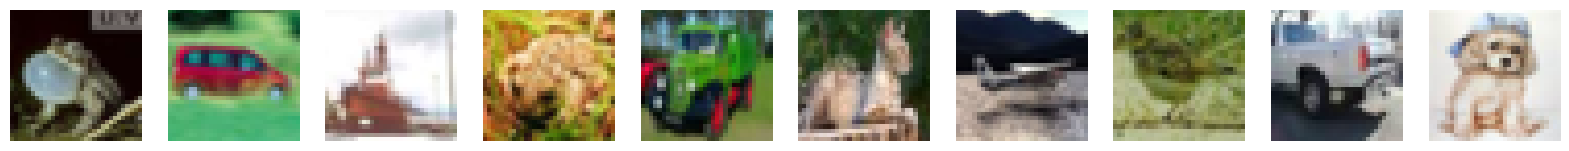

In [60]:
# Displaying the first 10 images, since we can't see the labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(testing_data[i])
    plt.axis('off')
plt.show() 

# [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck]
# So we should expect [6, 1, 8, 6, 9, 7, 8, 2, 9, 5] as the first 10 entries of our final CSV.

In [61]:
# Changing to Tensor and adjusting shape before test
testing_data = [(transform_image(image),) for image in testing_data]
print(testing_data[0][0].shape)

# DataLoader
testing_loader = DataLoader(testing_data, batch_size=128, shuffle=False)

torch.Size([3, 32, 32])


In [62]:
## Final output is file called submission.csv with columns ID, Labels

model.eval()
test_predictions = []

with torch.no_grad():
    for batch in testing_loader:
        images = batch[0].to(device) 
        outputs = model(images) 
        _, predictions = torch.max(outputs, dim=1)
        test_predictions.extend(predictions.cpu().numpy())

test_predictions_dict = {'ID': np.arange(len(test_predictions)), 'Labels': test_predictions}
test_predictions_df = pd.DataFrame(test_predictions_dict)
test_predictions_df.to_csv('submission1.csv', index=False)
print("Submitted! Check output for submission.csv")

Submitted! Check output for submission.csv
